There is a voluminous literature about how to measure causal impact using the differences-in-differences technique. It includes multiple controversies over how the technique can be applied to panel data with the problems of time-varying heterogeneity. These are fraught and varied issues, and we'll elide them for now. 

Instead we'll look at one of the earliest analyses in the literature, popularised by Card and Krueger in 1994. This is a justly famous paper both for the clear illustration of the technique and the conclusions drawn in their own right. It is not the earliest application of the technique. Arguably John Snow's cholera experiment in London demonstrates the exact same reasoning. But we want we to show how this quasi-experimental design is often employed today in a regression setting and how regression modelling is used to check the robustness of the DiD design. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

## The Data

The data from the Card and Krueger study reports measures of employement by location in bordering states of New Jersey and Pennsylvania afer April 1st, 1992 when New Jersey’s minimum wage rose from $4.25 to $5.05 per hour. The interest is in the effect of the different state policies relating to minimum wage. There is juncture in time after which New Jersey enacts a minimum wage policy which is anticipated to have a meaningful negative impact on employment figures. 


In [2]:
# Load the Data from the minumum wage study
df_ck = pd.read_csv('CK1994.txt', sep='\t')

## Calculate the price of an average meal.
df_ck['price'] = df_ck[['pricesoda', 'pricefry', 'priceentree']].sum(axis=1)

# Count of employees
df_ck['employees'] = df_ck.apply(lambda x: x['empft'] + x['nmgrs'] + 0.5*x['emppt'], axis=1)

# Interaction of state and time for use in OLS
df_ck['treatment'] = df_ck['state']*df_ck['time']

# Group by Region
df_ck['group'] = np.where(df_ck['southj'], 'NJ south',
                    np.where(df_ck['centralj'], 'NJ central', 
                      np.where(df_ck['northj'], 'NJ North', 
                        np.where(df_ck['pa1'], 'PA 1', 
                          np.where(df_ck['pa2'], 'PA 2', np.nan)))))


df_ck.head()

,store,chain,co_owned,state,southj,centralj,northj,pa1,pa2,shore,...,pricesoda,pricefry,priceentree,nregisters,nregisters11,time,price,employees,treatment,group
0,46,1,0,0,0,0,0,1,0,0,...,1.03,1.03,0.52,3.0,3.0,0,2.58,40.50,0,PA 1
1,49,2,0,0,0,0,0,1,0,0,...,1.01,0.90,2.35,4.0,3.0,0,4.26,13.75,0,PA 1
2,506,2,1,0,0,0,0,1,0,0,...,0.95,0.74,2.33,3.0,3.0,0,4.02,8.50,0,PA 1
3,56,4,1,0,0,0,0,1,0,0,...,0.87,0.82,1.79,2.0,2.0,0,3.48,34.00,0,PA 1
4,61,4,1,0,0,0,0,1,0,0,...,0.87,0.77,1.65,2.0,2.0,0,3.29,24.00,0,PA 1


The crucial results reported in the paper show a surprising subversion of expecation. The idea is that the neigbouring states should have comparable working conditions and incentives to employment up until the initiative of the policy change. Hence, it is argued that the difference between the states before and after the change can be a gauge of the causal impact of that policy. The data they looked at surveyed 410 fast-food restaurants in New Jersey and eastern Pennsylvania before and after the rise in minimum wage for New Jersey.


In [3]:
pivot = (df_ck[['state', 'time', 'employees']].dropna()
  .groupby(['state', 'time'])[['employees']].mean()
  .reset_index()
  .pivot(index='time', columns='state', values='employees')
  )
pivot = pivot.append(pivot.iloc[1] - pivot.iloc[0], ignore_index=True)
pivot.columns = ['PA', 'NJ']
pivot['Diff'] = pivot['NJ'] - pivot['PA']
pivot.index = ['Before', 'After', 'Diff']
pivot

/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_79529/4208568777.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pivot = pivot.append(pivot.iloc[1] - pivot.iloc[0], ignore_index=True)


,PA,NJ,Diff
Before,23.331169,20.439408,-2.891761
After,21.165584,21.027429,-0.138155
Diff,-2.165584,0.588021,2.753606


The result here is, by traditional economic logic, surprising in that they "find no indication that the rise in the minimum wage reduced employment." The above table reports the raw differences in average employment per restaurant. That's it. That's the quasi-experiemntal design that launched a thousand imitations. 


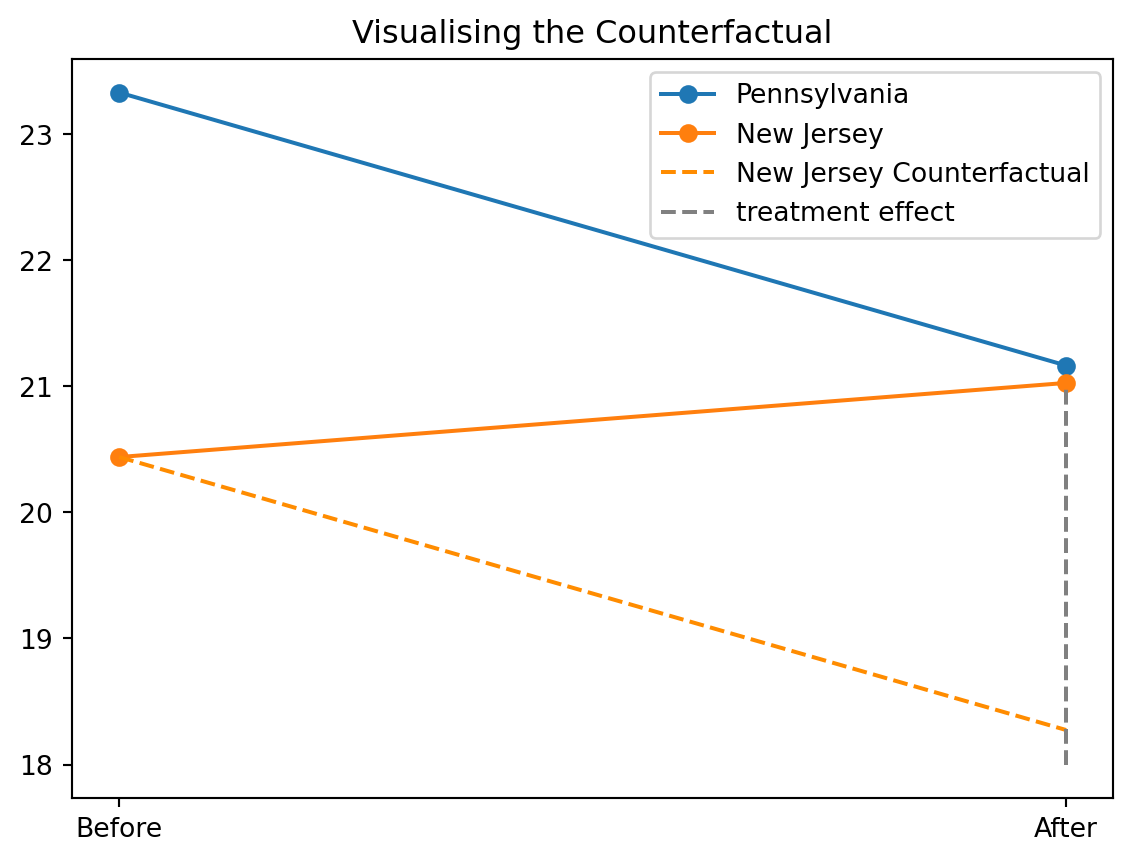

In [4]:
fig, ax = plt.subplots()
ax.plot(['Before', 'After'], [pivot.iloc[0]['PA'],  pivot.iloc[1]['PA']], '-o', label='Pennsylvania')
ax.plot(['Before', 'After'], [pivot.iloc[0]['NJ'],  pivot.iloc[1]['NJ']],'-o', label='New Jersey')
ax.plot(['Before', 'After'], [pivot.iloc[0]['NJ'],  pivot.iloc[2]['PA'] +pivot.iloc[0]['NJ']], '--', color='darkorange', label='New Jersey Counterfactual')
ax.set_title("Visualising the Counterfactual")
ax.plot((1, 1), (18, 21), '--', color='grey', label='treatment effect')
ax.legend()

## A Persuasive Design

It's not just a simple table. The paper was compelling precisely because the design was persuasive, and the Pennsylvania's future is a plausible representation of New Jersey's counterfactual future. 


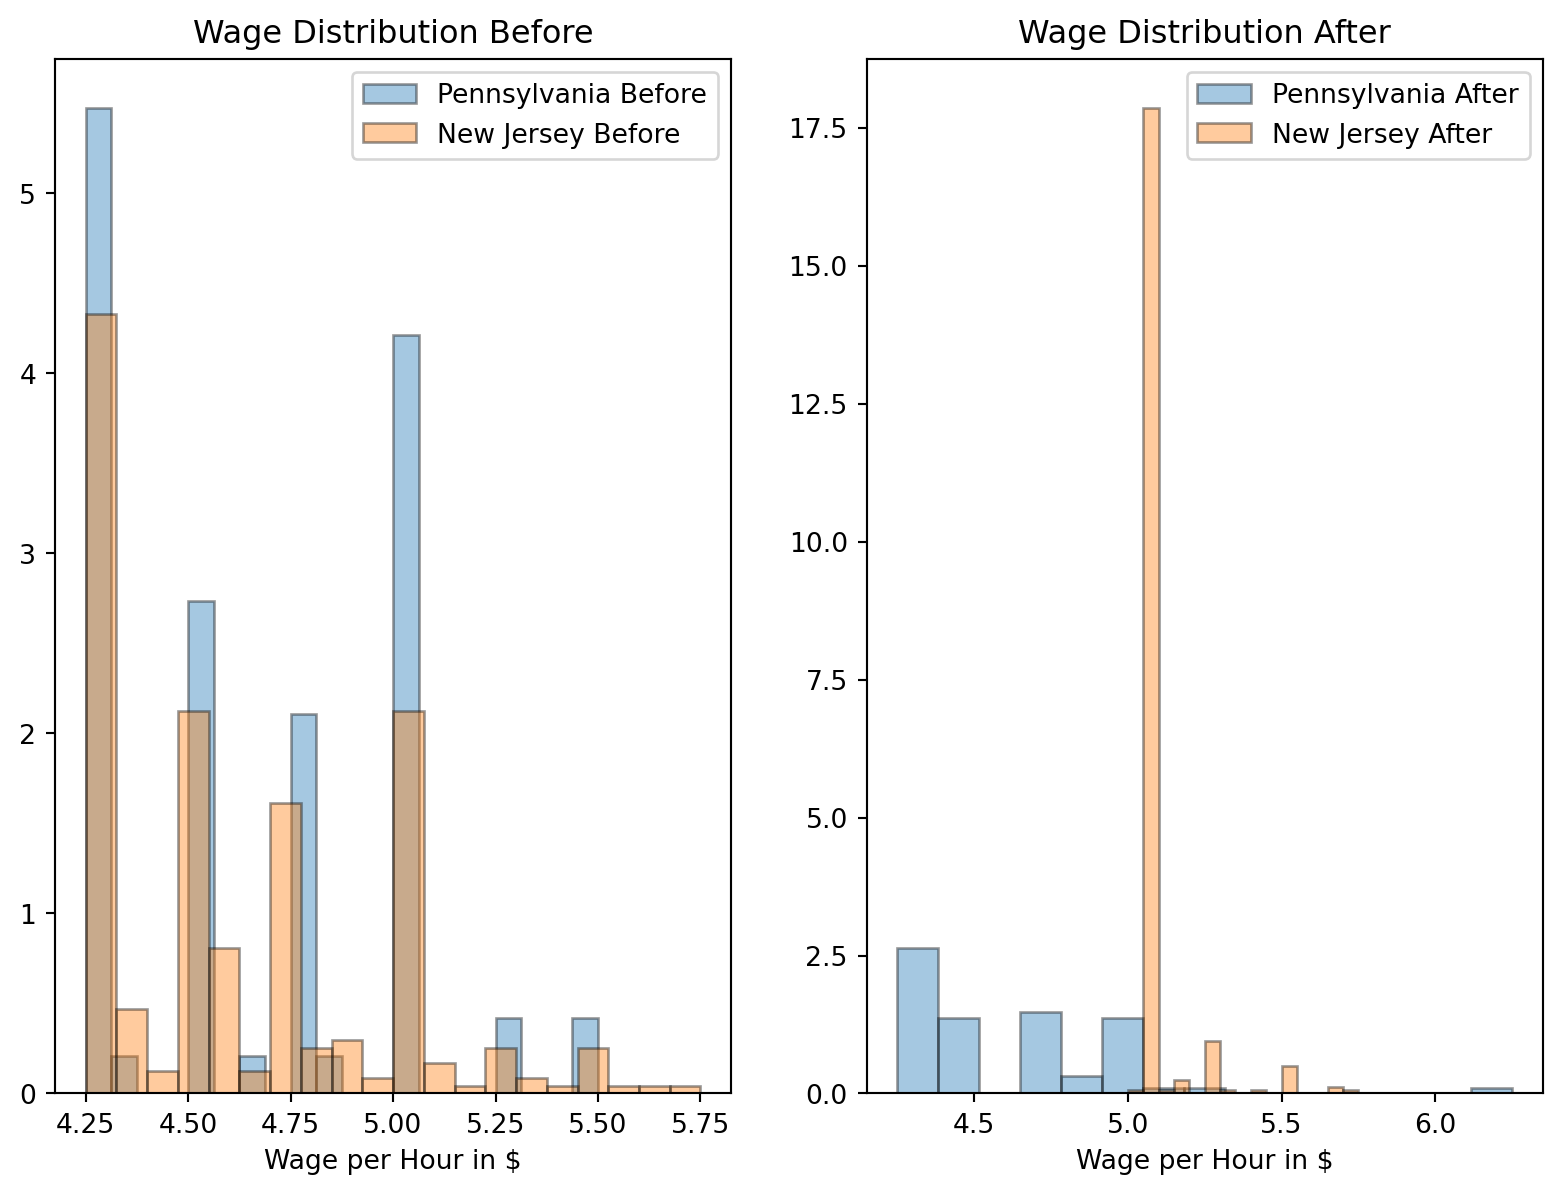

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7))
axs = axs.flatten()
before = df_ck[df_ck['time'] == 0]
after = df_ck[df_ck['time'] == 1]
axs[0].hist(before[before['state'] == 0]['wage_st'], alpha=0.4, bins=20, density=True, ec='black', label='Pennsylvania Before')
axs[0].hist(before[before['state'] == 1]['wage_st'], alpha=0.4, bins=20, density=True, ec='black', label='New Jersey Before')
axs[0].set_xlabel("Wage per Hour in $")
axs[0].legend()
axs[1].hist(after[after['state'] == 0]['wage_st'], alpha=0.4, bins=15, density=True, ec='black', label='Pennsylvania After')
axs[1].hist(after[after['state'] == 1]['wage_st'], alpha=0.4, bins=15, density=True, ec='black', label='New Jersey After')
axs[1].set_xlabel("Wage per Hour in $")
axs[1].legend()
axs[1].set_title("Wage Distribution After")
axs[0].set_title("Wage Distribution Before");

And the corressponding view for the employment figures shows that the difference between before and after periods, for both states are centered around zero. 


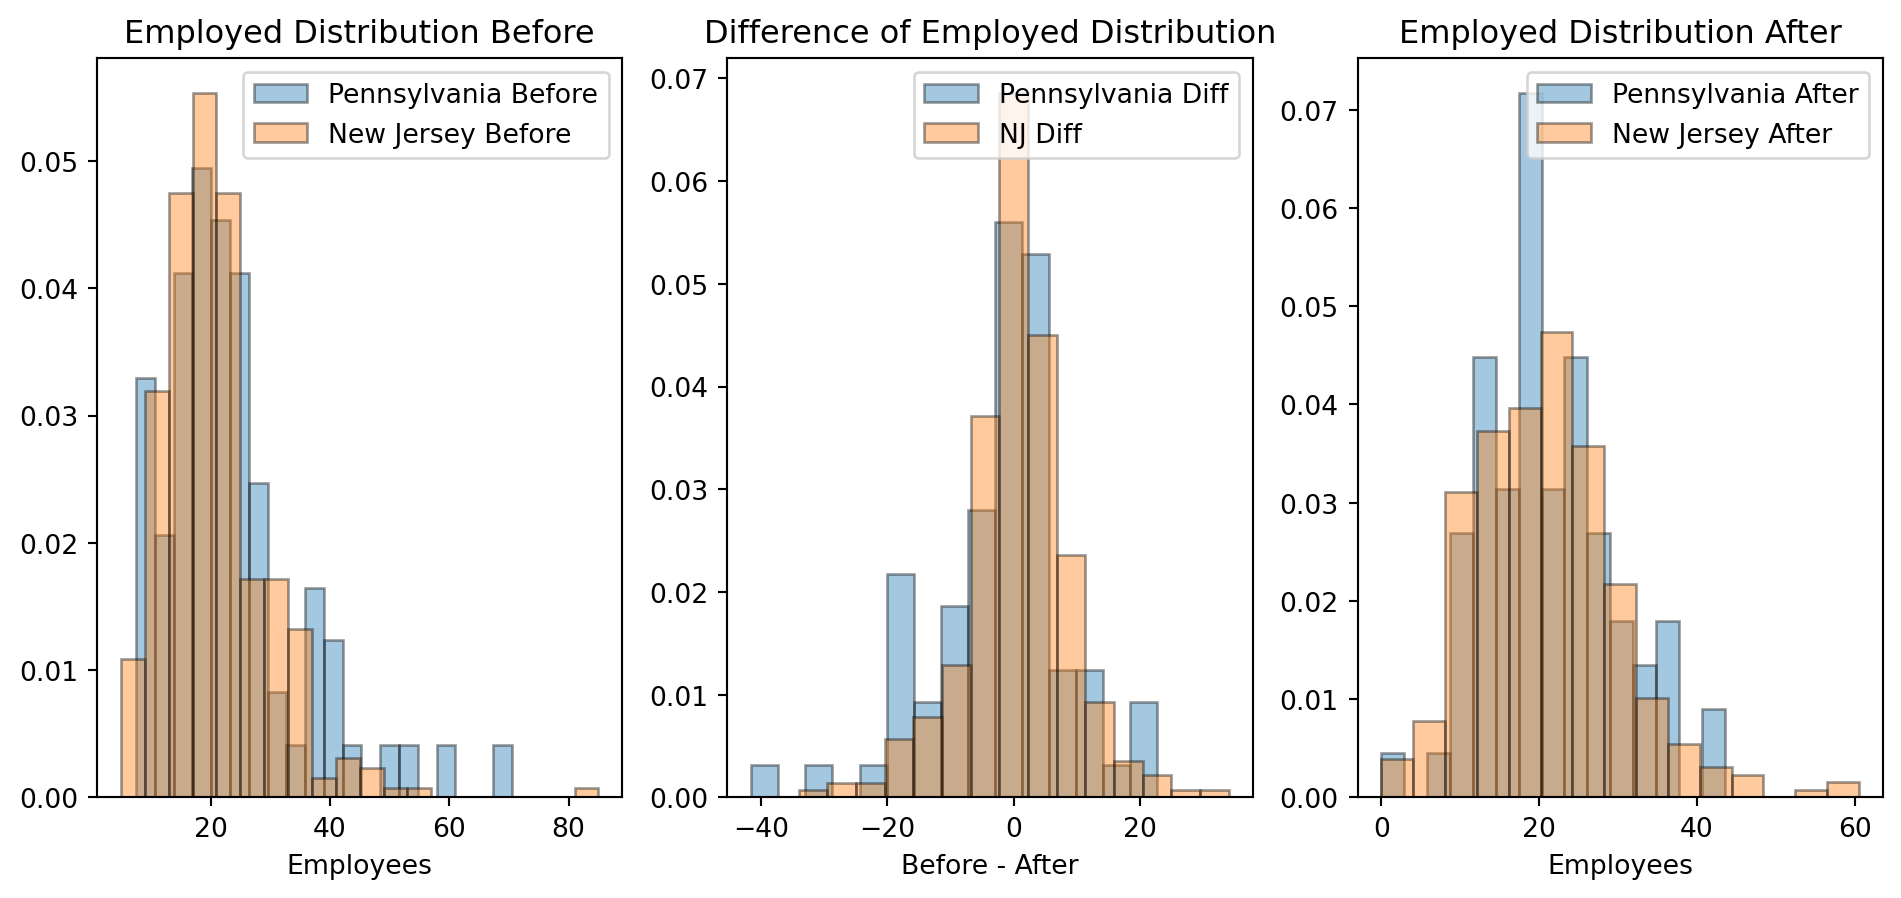

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(12, 5))
axs = axs.flatten()
before = df_ck[df_ck['time'] == 0]
after = df_ck[df_ck['time'] == 1]
axs[0].hist(before[before['state'] == 0]['employees'], alpha=0.4, bins=20, density=True, ec='black', label='Pennsylvania Before')
axs[0].hist(before[before['state'] == 1]['employees'], alpha=0.4, bins=20, density=True, ec='black', label='New Jersey Before')
axs[0].set_xlabel("Employees")
axs[0].legend()
axs[2].hist(after[after['state'] == 0]['employees'], alpha=0.4, bins=15, density=True, ec='black', label='Pennsylvania After')

diff_p = after[after['state'] == 0][['store', 'employees']].merge(before[before['state'] == 0][['store', 'employees']], left_on='store', right_on='store')

diff_nj = after[after['state'] == 1][['store', 'employees']].merge(before[before['state'] == 1][['store', 'employees']], left_on='store', right_on='store')

axs[1].hist(diff_p['employees_x'] - diff_p['employees_y'], alpha=0.4, bins=15, density=True, ec='black', label='Pennsylvania Diff')
axs[1].hist(diff_nj['employees_x'] - diff_nj['employees_y'], alpha=0.4, bins=15, density=True, ec='black', label='NJ Diff')
axs[1].set_xlabel("Before - After")
axs[1].legend()

axs[2].hist(after[after['state'] == 1]['employees'], alpha=0.4, bins=15, density=True, ec='black', label='New Jersey After')
axs[2].set_xlabel("Employees")
axs[2].legend()
axs[2].set_title("Employed Distribution After")
axs[1].set_title("Difference of Employed Distribution")
axs[0].set_title("Employed Distribution Before");


## Robustness to Controls

The robustness of the effect might, in principle, be moderated or refined by other factors. So it's worth exploring the parameter fits for a variety of models. First we recover the simple differences-in-differences control using regression, and then for other subsequent moodels we add controls for the the location, food chain and whether the restaurant is co-owned. All models recover effectively the same estimate for the interaction term of state over time, which is our differences-in-differences estimate. 


In [7]:
temp = df_ck[['employees', 'northj', 'centralj', 'pa1', 'pa2', 'time', 'treatment', 'chain', 'state', 'co_owned']].dropna()
temp[['chain_1', 'chain_2', 'chain_3', 'chain_4']] = pd.get_dummies(temp['chain'])
model_0 = smf.ols(formula='employees ~ state + time + treatment', data=temp).fit()
model_1 = smf.ols(formula='employees ~ state + time + chain_1 + chain_2 + chain_3 + treatment', data=temp).fit()
model_2 = smf.ols(formula='employees ~ centralj + pa1 + pa2 + time + treatment', data=temp).fit()

model_3 = smf.ols(formula='employees ~ centralj + pa1 + pa2 + time + chain_1 + chain_2 + chain_3 + treatment', data=temp).fit()

model_4 = smf.ols(formula='employees ~ centralj + pa1 + pa2 + time + chain_1 + chain_2 + chain_3 + co_owned + treatment', data=temp).fit()

stargazer = Stargazer([model_0, model_1, model_2, model_3])
stargazer.render_html()

'<table style="text-align:center"><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="4"><em>Dependent variable:employees</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td><td>(4)</td></tr><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Intercept</td><td>23.331<sup>***</sup></td><td>24.613<sup>***</sup></td><td>20.196<sup>***</sup></td><td>21.960<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(1.072)</td><td>(1.194)</td><td>(0.554)</td><td>(0.909)</td></tr><tr><td style="text-align:left">centralj</td><td></td><td></td><td>1.304<sup></sup></td><td>1.458<sup>*</sup></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td>(0.949)</td><td>(0.858)</td></tr><tr><td style="text-align:left">chain_1</td><td></td><td>1.118<sup></sup></td><td></td><td>1.185<sup></sup></td></tr>

The effect is consisteny across the model specification. This is evidence of a robust effect. What happens if we look at a different outcome variable? Does the change in policy impact the price of the meal by location?


In [8]:
temp = df_ck[['price', 'northj', 'centralj', 'pa1', 'pa2', 'time', 'treatment', 'chain', 'state', 'co_owned']].dropna()
temp[['chain_1', 'chain_2', 'chain_3', 'chain_4']] = pd.get_dummies(temp['chain'])
model_0 = smf.ols(formula='price ~ state + time + treatment', data=temp).fit()
model_1 = smf.ols(formula='price ~ state + time + chain_1 + chain_2 + chain_3 + treatment', data=temp).fit()
model_2 = smf.ols(formula='price ~ centralj + pa1 + pa2 + time + treatment', data=temp).fit()

model_3 = smf.ols(formula='price ~ centralj + pa1 + pa2 + time + chain_1 + chain_2 + chain_3 + treatment', data=temp).fit()

model_4 = smf.ols(formula='price ~ centralj + pa1 + pa2 + time + chain_1 + chain_2 + chain_3 + co_owned + treatment', data=temp).fit()

stargazer = Stargazer([model_0, model_1, model_2, model_3])
stargazer.render_html()

'<table style="text-align:center"><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="4"><em>Dependent variable:price</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td><td>(4)</td></tr><tr><td colspan="5" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Intercept</td><td>2.955<sup>***</sup></td><td>2.876<sup>***</sup></td><td>3.243<sup>***</sup></td><td>3.097<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(0.098)</td><td>(0.094)</td><td>(0.051)</td><td>(0.071)</td></tr><tr><td style="text-align:left">centralj</td><td></td><td></td><td>0.027<sup></sup></td><td>0.013<sup></sup></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td>(0.086)</td><td>(0.067)</td></tr><tr><td style="text-align:left">chain_1</td><td></td><td>-0.239<sup>***</sup></td><td></td><td>-0.241<sup>***</sup></td></tr><

## Impact on Consumers?

The effects on price of a meal is much more stable and seemingly not impacted in the same degree as we saw in employment numbers. In fact the effects seem close to negligible. This contextual information suggests that the increased wages have not lead (in the same timeframe) to extra costs for the consumer. 


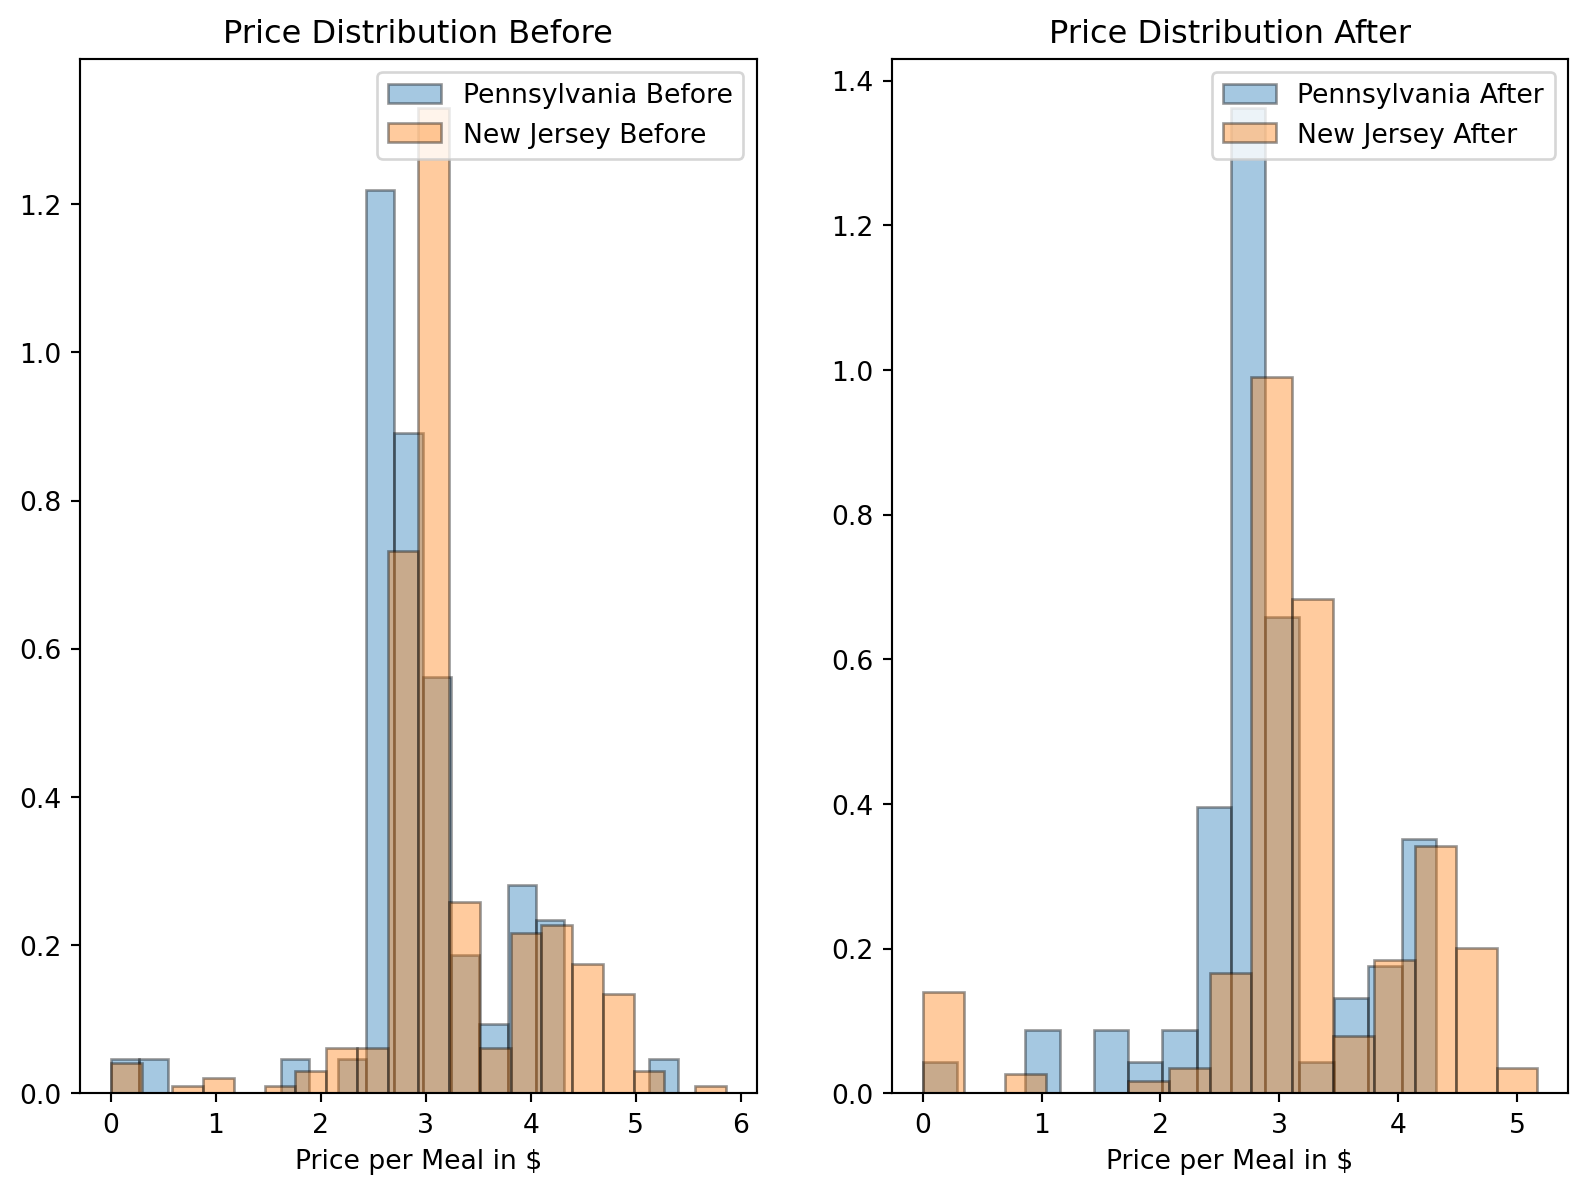

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(10, 7))
axs = axs.flatten()
before = df_ck[df_ck['time'] == 0]
after = df_ck[df_ck['time'] == 1]
axs[0].hist(before[before['state'] == 0]['price'], alpha=0.4, bins=20, density=True, ec='black', label='Pennsylvania Before')
axs[0].hist(before[before['state'] == 1]['price'], alpha=0.4, bins=20, density=True, ec='black', label='New Jersey Before')
axs[0].set_xlabel("Price per Meal in $")
axs[0].legend()
axs[1].hist(after[after['state'] == 0]['price'], alpha=0.4, bins=15, density=True, ec='black', label='Pennsylvania After')
axs[1].hist(after[after['state'] == 1]['price'], alpha=0.4, bins=15, density=True, ec='black', label='New Jersey After')
axs[1].set_xlabel("Price per Meal in $")
axs[1].legend()
axs[1].set_title("Price Distribution After")
axs[0].set_title("Price Distribution Before");


It is this combination of details that made the Card and Kreuger study surprising and impactful. There is a clear quasi-experimental design, a compelling narrative and a counter-intuitive conclusion. We won't speak the wider discussion of minimum wages in economics, our focus here is on the methodology.  The methodology almost seems too simple, too straightforward. Much of the plausibility of the inferences gets bundled into the contrast between the treatment group and our pseudo-control. So far we've avoided precise mathematical statement of the DiD estimator, but being more precise allows us to say something about when this estimation technique can go wrong. 

## When DiD goes Wrong

Following Scott Cunningham's presentation we can view the simple 2x2 DiD estimate as follows

$$\widehat{\delta}^{2\times 2}_{tC} = \bigg(E\big[Y_t  | Post\big] - E\big[Y_t  | Pre\big]\bigg)- \bigg(E\big[Y_C  | Post\big] - E\big[Y_C  | Pre\big]\bigg)$$

which  is equivalent to: 

$$ \begin{align}
&\widehat{\delta}^{2\times 2}_{tC} = \underbrace{E\big[Y^1_t  | Post\big] - E\big[Y^0_t | Post\big]}_{\text{ATT}} \\
&+\Big[\underbrace{E\big[Y^0_t | Post\big] - E\big[Y^0_t | Pre\big] \Big] - \Big[E\big[Y^0_C  | Post\big] - E\big[Y_C^0 | Pre\big] }_{\text{Non-parallel trends bias in $2\times 2$ case}} \Big]
\end{align}
$$

which implies that we can extract that the average treatment effect on the treated (ATT) can be estimated just so long as the bias due to the parallel trends zeros out. In our applied case this amounts to the following

$$
\begin{align}
&\widehat{\delta}^{2\times 2}_{NJ,PA} = \underbrace{E\big[Y^1_{NJ} | Post\big] - E\big[Y^0_{NJ} | Post\big]}_{\text{ATT}} \\
&+ \Big[\underbrace{E\big[Y^0_{NJ} | Post\big] - E\big[Y^0_{NJ} | Pre\big] \Big]-\Big[E\big[Y^0_{PA} | Post\big] - E\big[Y_{PA}^0 | Pre\big] }_{\text{Non-parallel trends bias}} \Big]
\end{align}
$$

which is to say that the causal impact discovered by a DiD design is valid just when for both states there would have been a parrallel trend, under the counterfactual, where the treatment had not been applied to New Jersey, i.e. had the treatment not been applied then the differences between the states would have remained stable. 

### Testing the Parallel Trends Assumption

We'll examine a larger data set discussed by Scott Cunningham in his *Causal Inference: The Mixtape*. The point is to see how to measure the similarity of the trends prior to an intervention. The rhetorical move in a differences in differences design is heavily reliant on how compelling you can make the counterfactual claim. The data we look at focuses on the staggered rollout of the Roe v Wade decision across states on the effects of gonnoherea in the repeal v non-appeal states after the beginning of the rollout. In our data set we'll see the differential rates of gonnoherea by demographic information. 


/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_79529/3799677275.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ax.plot(abortion.pivot('year', 'fip', 'lnr').mean(axis=1), color='darkblue',  label='Overall Average')
/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_79529/3799677275.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ax.plot(abortion[abortion['repeal'] == 0].pivot('year', 'fip', 'lnr').mean(axis=1), label='Average in Non Repeal States', color='slateblue')
/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_79529/3799677275.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  ax.plot(abortion[abortion['repeal'] == 1].pivot('year', 'fip', 'lnr').mean(axis=1), label='Average in Repeal States', color='royalblue')


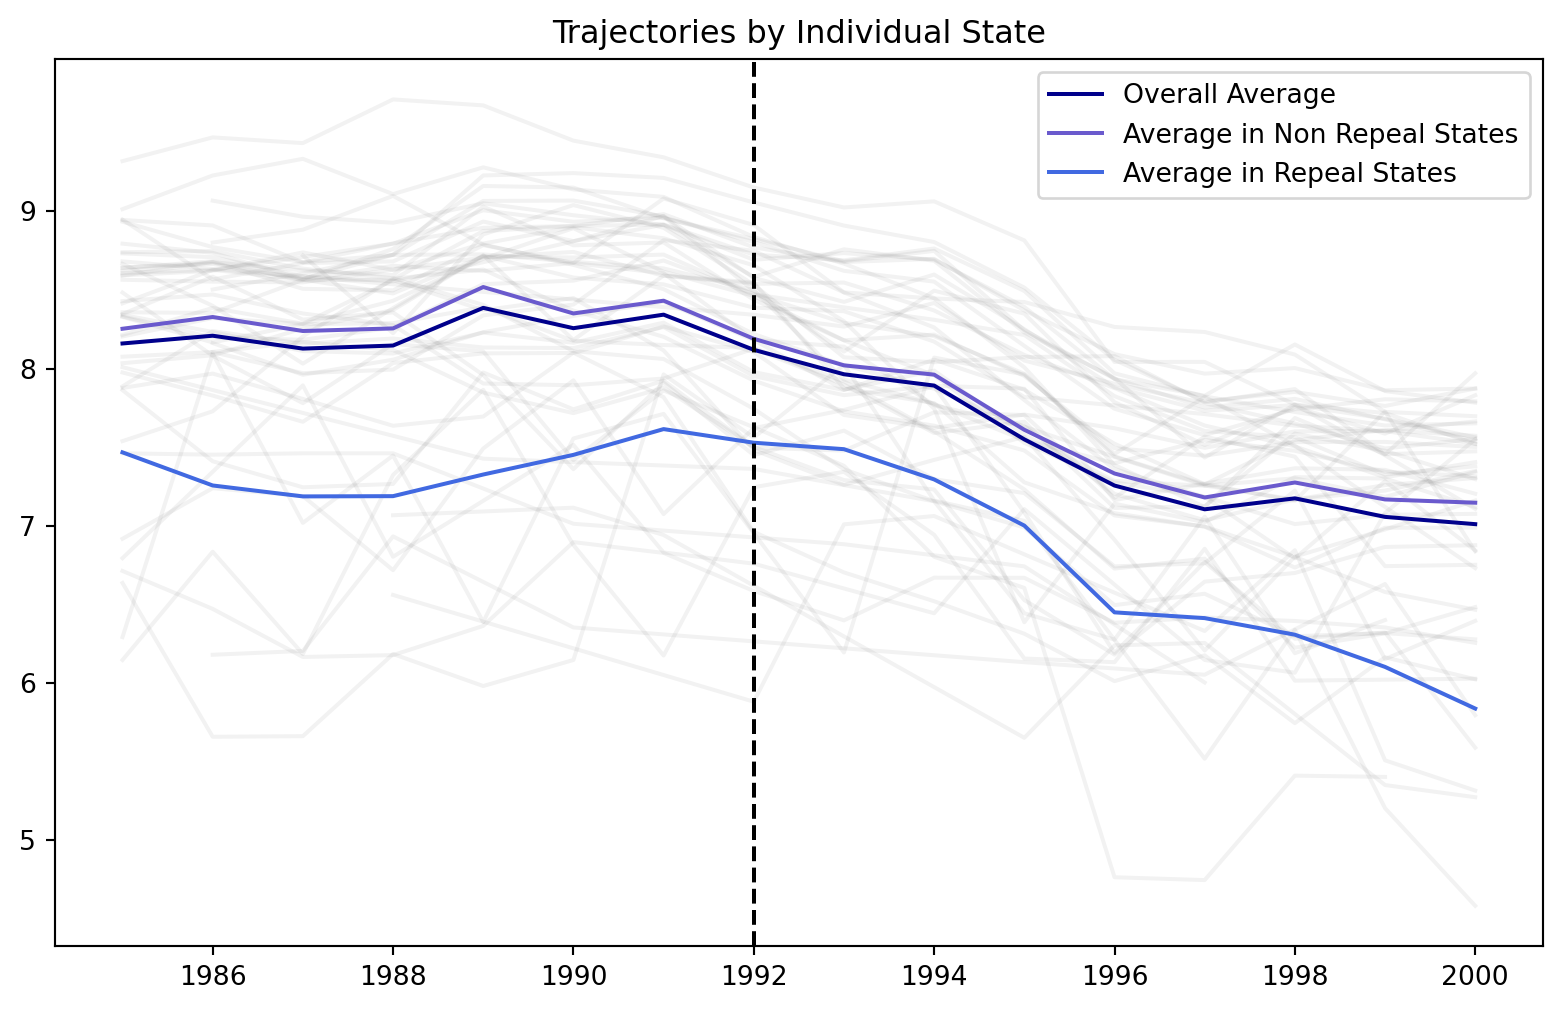

In [10]:
abortion = pd.read_csv('abortion_mixtape.csv')
abortion = abortion[~pd.isnull(abortion.lnr)]
abortion = abortion[abortion.bm15==1]

fig, ax = plt.subplots(figsize=(10, 6))
for i in abortion['fip'].unique():
  temp = abortion[abortion['fip'] == i]
  temp.set_index('year', inplace=True)
  ax.plot(temp['lnr'], color='grey', alpha=0.1)
ax.set_title("Trajectories by Individual State")
ax.plot(abortion.pivot('year', 'fip', 'lnr').mean(axis=1), color='darkblue',  label='Overall Average')
ax.plot(abortion[abortion['repeal'] == 0].pivot('year', 'fip', 'lnr').mean(axis=1), label='Average in Non Repeal States', color='slateblue')
ax.plot(abortion[abortion['repeal'] == 1].pivot('year', 'fip', 'lnr').mean(axis=1), label='Average in Repeal States', color='royalblue')
ax.axvline(1992, color='black', linestyle='--')
ax.legend();

Scott wants to test a prediction of the literature that this intervention should result in a **parabolic curve**, where the original stark difference between the repeal and Non-repeal states converges towards zero after the 1992 decision.

> In 1986, only one cohort (the 1971 cohort) was treated and only in the repeal states. Therefore, we should see small declines in gonorrhea incidence among 15-year-olds in 1986 relative to Roe states. In 1987, two cohorts in our data are treated in the repeal states relative to Roe, so we should see larger effects in absolute value than we saw in 1986. But from 1988 to 1991, we should at most see only three net treated cohorts in the repeal states because starting in 1988, the Roe state cohorts enter and begin erasing those differences. Starting in 1992, the effects should get smaller in absolute value until 1992, beyond which there should be no difference between repeal and Roe states.

Implying that the tratment effect should result in a growth trajectory with a distinctive shape. 

## Fitting Regressions to Evaluate Event Studies

We want now to measure the efficacy of the treatment as a function of each time point while controlling for other factors. This can be achieved using a regression model specification for the DiD model which measures the impact at each time-point. The point to keep in mind is that this process measures the same thing as  the simpler DiD estimate above, but here our interaction of group and time effects occurs across multiple time points. This is a significant step-up in complexity of the regression modelling common in econometric approaches. Much of the sophistication in econometric-style causal inference stems from a thorough understanding of OLS estimation strategies and creative uses of the properties of these estimators. 

We will specify three distinct model specifications and assess the inferences available on each of the core parameters. Each model will contain the interaction effect terms of time (`year`) and treatment (`repeal`) and we will use the individual estimates to plot the graduated effect of the policy program. We will include progressively fewer control variables to show how different model specifications change the story. 


In [11]:
formula = (
    "lnr ~ C(repeal)*C(year) + C(fip)"
    " + acc + ir + pi + alcohol + crack + poverty + income + ur"
)

formula_1 = (
    "lnr ~ C(repeal)*C(year) + C(fip)"
    " + acc + ir + pi + alcohol + crack"
)

formula_2 = (
    "lnr ~ C(repeal)*C(year) + C(fip)"
)

reg = (
    smf
    .wls(formula, data=abortion, weights=abortion.totpop.values)
    .fit(
        cov_type='cluster', 
        cov_kwds={'groups': abortion.fip.values}, 
        method='pinv'
        )
)

reg1 = (
    smf
    .wls(formula_1, data=abortion, weights=abortion.totpop.values)
    .fit(
        cov_type='cluster', 
        cov_kwds={'groups': abortion.fip.values}, 
        method='pinv'
        )
)

reg2 = (
    smf
    .wls(formula_2, data=abortion, weights=abortion.totpop.values)
    .fit(
        cov_type='cluster', 
        cov_kwds={'groups': abortion.fip.values}, 
        method='pinv'
        )
)


stargazer = Stargazer([reg, reg1, reg2])
stargazer


/Users/nathanielforde/Documents/Github/NathanielF.github.io/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 89, but rank is 27
  warnings.warn('covariance of constraints does not have full '
/Users/nathanielforde/Documents/Github/NathanielF.github.io/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 86, but rank is 24
  warnings.warn('covariance of constraints does not have full '
/Users/nathanielforde/Documents/Github/NathanielF.github.io/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 81, but rank is 19
  warnings.warn('covariance of constraints does not have full '


Using these regressions we can plot the interaction effect of treatment and time. If the DiD design is to be plausible we should see a change in the effect at the point of the treatment date. Note how we extract the confidence interval around the parameter estimates for the interaction of the treatment and time effects. We then use this to plot the graduated impact of the treatment. 


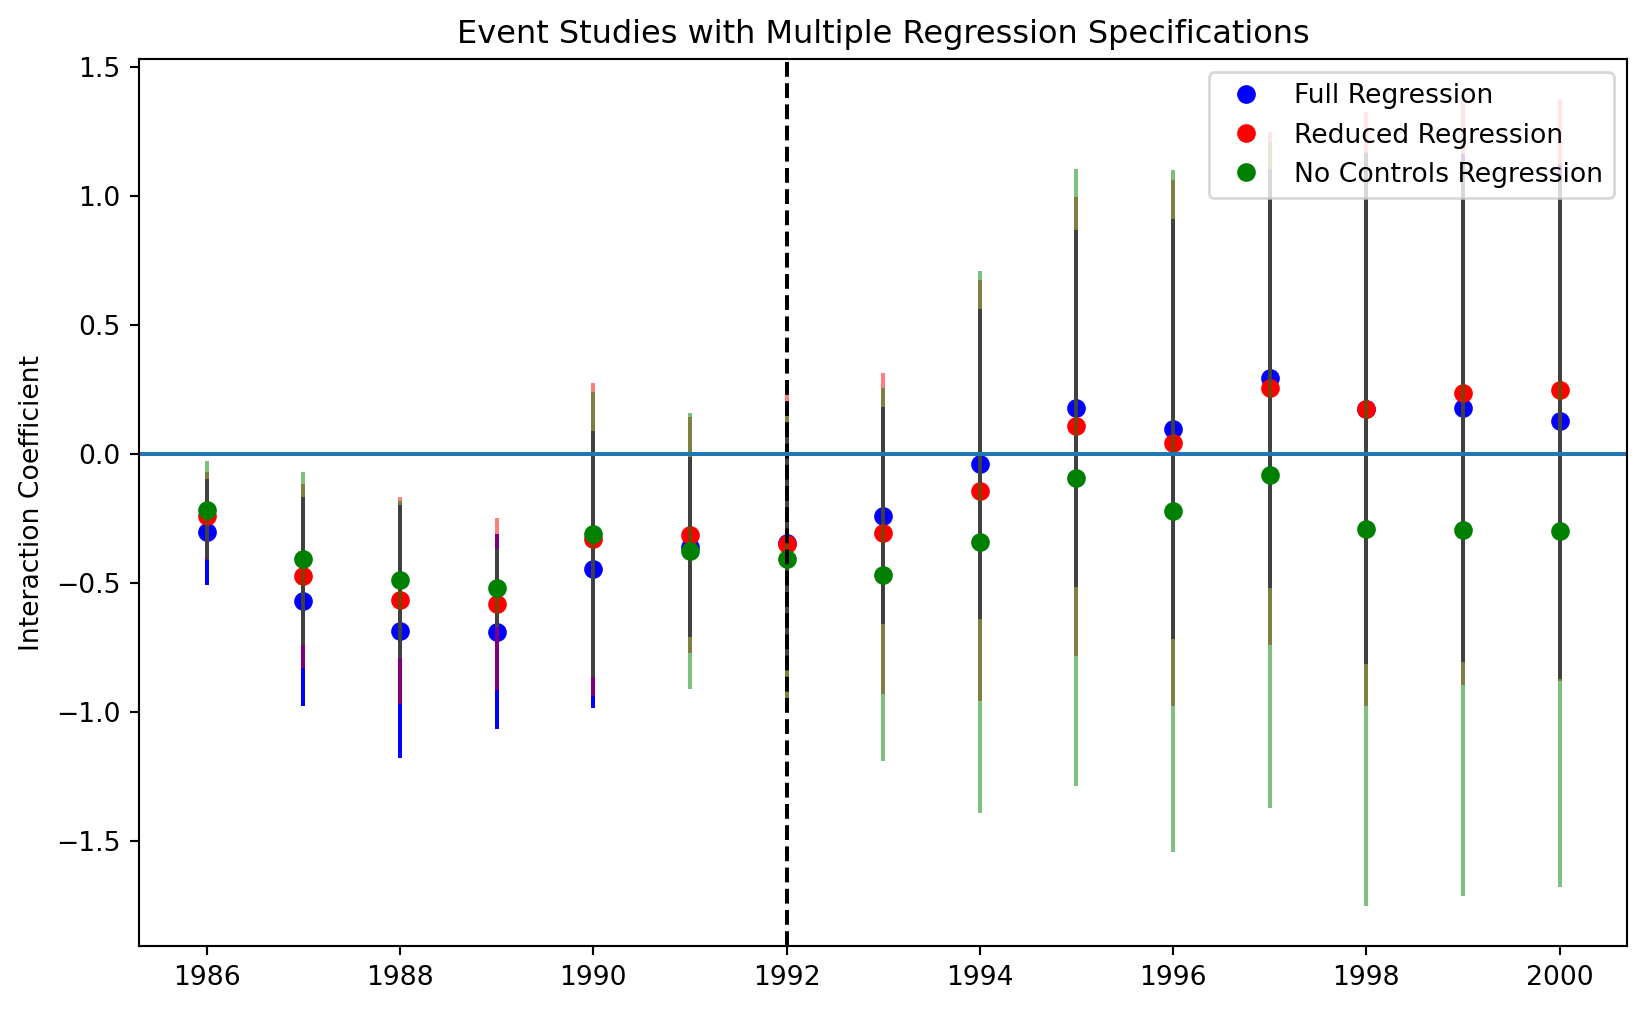

In [12]:
def make_regression_plot(reg):
  abortion_plot = pd.DataFrame(
      {
          'sd': reg.bse['C(repeal)[T.1.0]:C(year)[T.1986.0]':'C(repeal)[T.1.0]:C(year)[T.2000.0]'],
          'mean': reg.params['C(repeal)[T.1.0]:C(year)[T.1986.0]':'C(repeal)[T.1.0]:C(year)[T.2000.0]'],
          'year': np.arange(1986, 2001)
      })
  abortion_plot['lb'] = abortion_plot['mean'] - abortion_plot['sd']*1.96
  abortion_plot['ub'] = abortion_plot['mean'] + abortion_plot['sd']*1.96
  abortion_plot.set_index('year', inplace=True)
  return abortion_plot


abortion_plot = make_regression_plot(reg)
abortion_plot1 = make_regression_plot(reg1)
abortion_plot2 = make_regression_plot(reg2)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(abortion_plot['mean'], 'o', color='blue', label='Full Regression')[0]
ax.vlines(x=abortion_plot.index, ymin=abortion_plot['lb'], ymax=abortion_plot['ub'], color='blue')
ax.plot(abortion_plot1['mean'], 'o', color='red', label="Reduced Regression")[0]
ax.vlines(x=abortion_plot1.index, ymin=abortion_plot1['lb'], ymax=abortion_plot1['ub'], color='red', alpha=0.5)

ax.plot(abortion_plot2['mean'], 'o', color='green', label="No Controls Regression")[0]
ax.vlines(x=abortion_plot2.index, ymin=abortion_plot2['lb'], ymax=abortion_plot2['ub'], color='green', alpha=0.5)
ax.legend()
ax.set_ylabel("Interaction Coefficient")
ax.set_title("Event Studies with Multiple Regression Specifications")
ax.axvline(1992, color='black', linestyle='--')
ax.axhline(0);

We can see here how the temporal points before the introduction of Roe show an effect on the interaction coefficient. Which rises towards 0 after Roe just so long as we control for the independent effects of extra covariates. This suggests some evidence for the contention that the change in legislation will alter the parabolic trajectory. 

## Fitting a Placebo Model

We can further test this design if we model the effects of time on a placebo group at the same time. Here we'll take as a placebo group a cohort of a greater age, where the effect of Roe is less likely to have an impact on the rates of gonorrhea in the cohort. In this way we have a kind of pseudo placebo group for our treatment. I've used similar approaches in work to analyse speed improvements made to in-app pages that were exposed to a certain treatment effects compared against pseudo treatment groups that we deemed less likely to be impacted by the implemented change.


In [13]:
abortion = pd.read_csv('abortion_mixtape.csv')
abortion = abortion[~pd.isnull(abortion.lnr)]
abortion['yr'] = 0
abortion.loc[(abortion.younger==1) & (abortion.repeal==1), 'yr'] = 1

abortion['wm'] = 0
abortion.loc[(abortion.wht==1) & (abortion.male==1), 'wm'] = 1

abortion['wf'] = 0
abortion.loc[(abortion.wht==1) & (abortion.male==0), 'wf'] = 1

abortion['bm'] = 0
abortion.loc[(abortion.wht==0) & (abortion.male==1), 'bm'] = 1

abortion['bf'] = 0
abortion.loc[(abortion.wht==0) & (abortion.male==0), 'bf'] = 1


abortion_filt = abortion[(abortion.bm==1) & (abortion.age.isin([15,25]))]
abortion_filt

,Unnamed: 0,fip,age,race,year,sex,totcase,totpop,rate,totrate,...,pi,wm15,wf15,bm15,bf15,yr,wm,wf,bm,bf
13,13,1.0,25.0,2.0,1985.0,1,3969.0,84353,5682.9,4705.2,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0
22,22,1.0,15.0,2.0,1985.0,1,5683.0,106187,4153.4,5351.9,...,0.0,0.0,0.0,1.0,0.0,0,0,0,1,0
26,26,1.0,15.0,2.0,1986.0,1,5344.0,106831,3628.9,5002.3,...,0.0,0.0,0.0,1.0,0.0,0,0,0,1,0
38,38,1.0,25.0,2.0,1986.0,1,3162.0,84593,4509.4,3737.9,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0
50,50,1.0,25.0,2.0,1987.0,1,2650.0,84003,3754.1,3154.6,...,0.0,0.0,0.0,0.0,0.0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19460,19460,56.0,15.0,2.0,1995.0,1,2.0,379,471.7,527.7,...,1.0,0.0,0.0,1.0,0.0,0,0,0,1,0
19475,19475,56.0,15.0,2.0,1996.0,1,2.0,388,460.8,515.5,...,1.0,0.0,0.0,1.0,0.0,0,0,0,1,0
19488,19488,56.0,15.0,2.0,1997.0,1,2.0,355,947.9,563.4,...,1.0,0.0,0.0,1.0,0.0,0,0,0,1,0
19524,19524,56.0,15.0,2.0,1998.0,1,1.0,408,409.8,245.1,...,1.0,0.0,0.0,1.0,0.0,0,0,0,1,0


The benefit to allowing for a placebo factor is to test how the effect should remain pretty static in the group for which the treatment is unlikey to have an effect. This can strengthen or weaken the plausibility of the claim that the parrallel trends assumption holds. 


/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_79529/824042692.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  pivot = pivot.pivot(['year', 'younger'], 'repeal', 'lnr')


year       1985.0              1986.0              1987.0              1988.0  \
younger       0.0       1.0       0.0       1.0       0.0       1.0       0.0   
repeal                                                                          
0.0      8.455438  8.253097  8.295281  8.327786  8.188281  8.238825  8.145482   
1.0      8.050839  7.467163  7.967474  7.256647  7.550540  7.187125  7.362501   
1.0     -0.404599 -0.785934 -0.327807 -1.071139 -0.637740 -1.051699 -0.782981   

year                 1989.0            ...    1996.0              1997.0  \
younger       1.0       0.0       1.0  ...       0.0       1.0       0.0   
repeal                                 ...                                 
0.0      8.255206  8.118427  8.518338  ...  7.276521  7.332863  7.328013   
1.0      7.188717  7.232254  7.326252  ...  6.458796  6.449874  6.302575   
1.0     -1.066489 -0.886173 -1.192086  ... -0.817726 -0.882989 -1.025438   

year                 1998.0              1999.0              2000.0            
younger       1.0       0.0       1.0       0.0       1.0       0.0       1.0  
repeal                                                                         
0.0      7.180292  7.449080  7.275626  7.350274  7.167805  7.393483  7.147023  
1.0      6.413239  6.547882  6.307862  6.400939  6.102952  6.477026  5.838150  
1.0     -0.767054 -0.901198 -0.967764 -0.949336 -1.064853 -0.916457 -1.308873  

[3 rows x 32 columns]

/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_79529/824042692.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  diff = pivot.iloc[2].reset_index().pivot('year', 'younger', 1.0)


Text(0.5, 1.0, 'Diff in Diff by Treatment by Year')

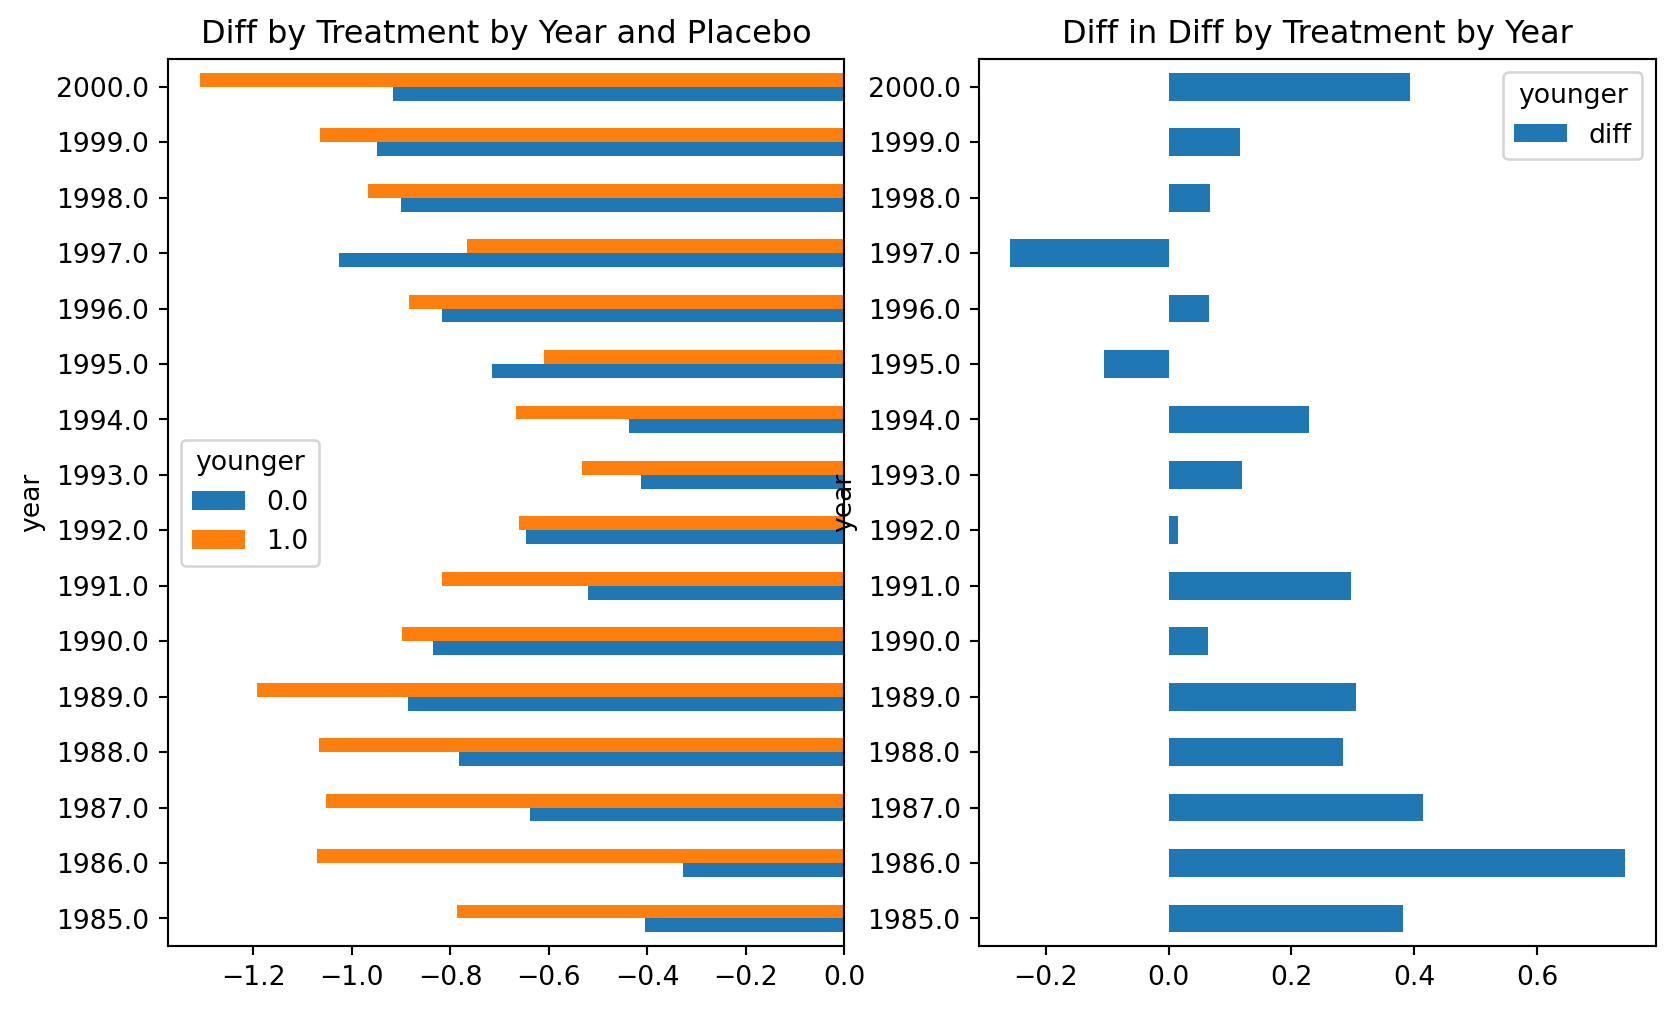

In [14]:
pivot = abortion_filt.groupby(['repeal', 'younger', 'year'])['lnr'].mean().reset_index()
pivot = pivot.pivot(['year', 'younger'], 'repeal', 'lnr')
pivot = pd.concat([pivot.T, pivot.T.diff()]).dropna()
display(pivot)
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
axs = axs.flatten()
diff = pivot.iloc[2].reset_index().pivot('year', 'younger', 1.0)
diff.plot(kind='barh', ax=axs[0])
diff['diff'] = diff[0] - diff[1]
diff[['diff']].plot(kind='barh', ax=axs[1])
axs[0].set_title("Diff by Treatment by Year and Placebo")
axs[1].set_title("Diff in Diff by Treatment by Year")

From the simple contrast above, evidence of a treatment effect seems mixed with both positive and negative effects centered on zero in the post treatment years. This type of placebo design can be specified using a complex regression equation. The equation relies on interaction terms as before with the simpler DiD design, but now we also include interactions for the placebo group. 


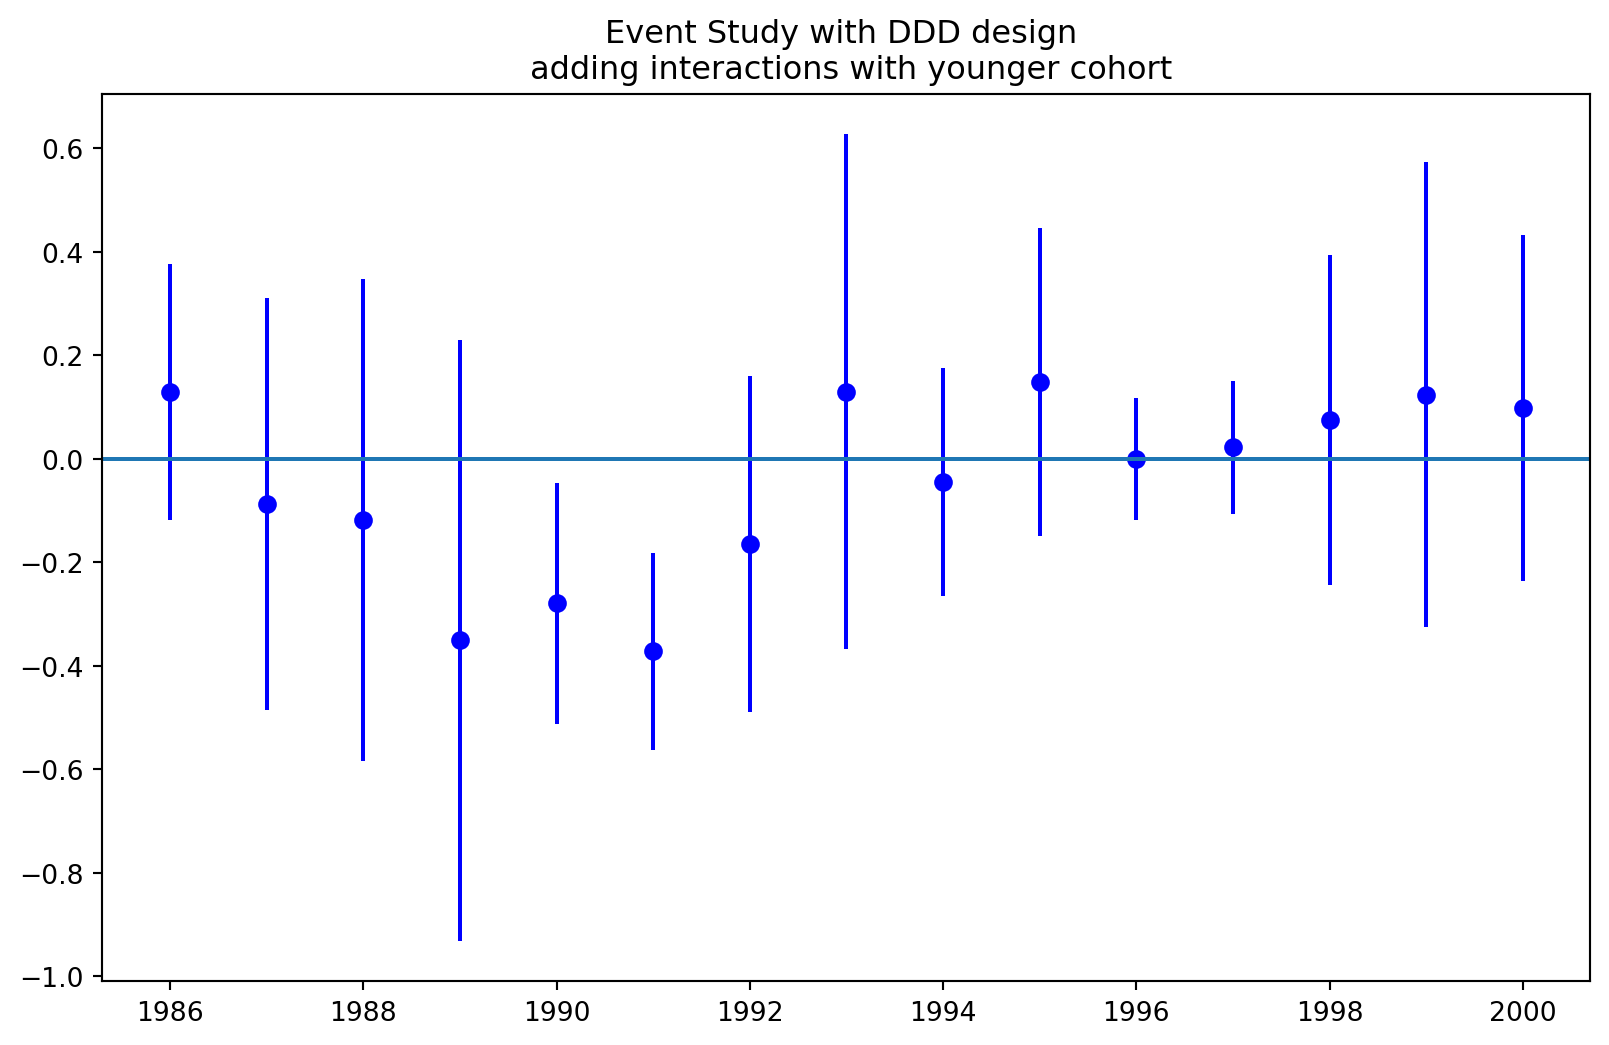

In [15]:
reg = (
    smf
    .wls("""lnr ~ C(repeal)*C(year) + C(younger)*C(repeal) + C(younger)*C(year) + 
C(yr)*C(year) + C(fip)*t + acc + ir + pi + alcohol + crack + poverty + income + ur""", 
        data=abortion_filt, weights=abortion_filt.totpop.values)
    .fit(
        cov_type='cluster', 
        cov_kwds={'groups': abortion_filt.fip.values}, 
        method='pinv')
)

abortion_plot = make_regression_plot(reg)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(abortion_plot['mean'], 'o', color='blue')[0]
ax.vlines(x=abortion_plot.index, ymin=abortion_plot['lb'], ymax=abortion_plot['ub'], color='blue')
ax.axhline(0)
ax.set_title("Event Study with DDD design \n adding interactions with younger cohort");

We can alternatively test the diff in diff model seperately to show how there is a less pronounced effect for these two groups with the older group providing evidence against the hypothesis of a parabolic like treatment effect.  To reiterate that last point we can estimate the model seperately on different age cohorts and judge whether the treatment effect had a similar graduated effect in both cohorts. The older group appear to have less of a sustained treatment effect and counts as evidence against the theory of a graduated parabolic change due to the Roe decision. 


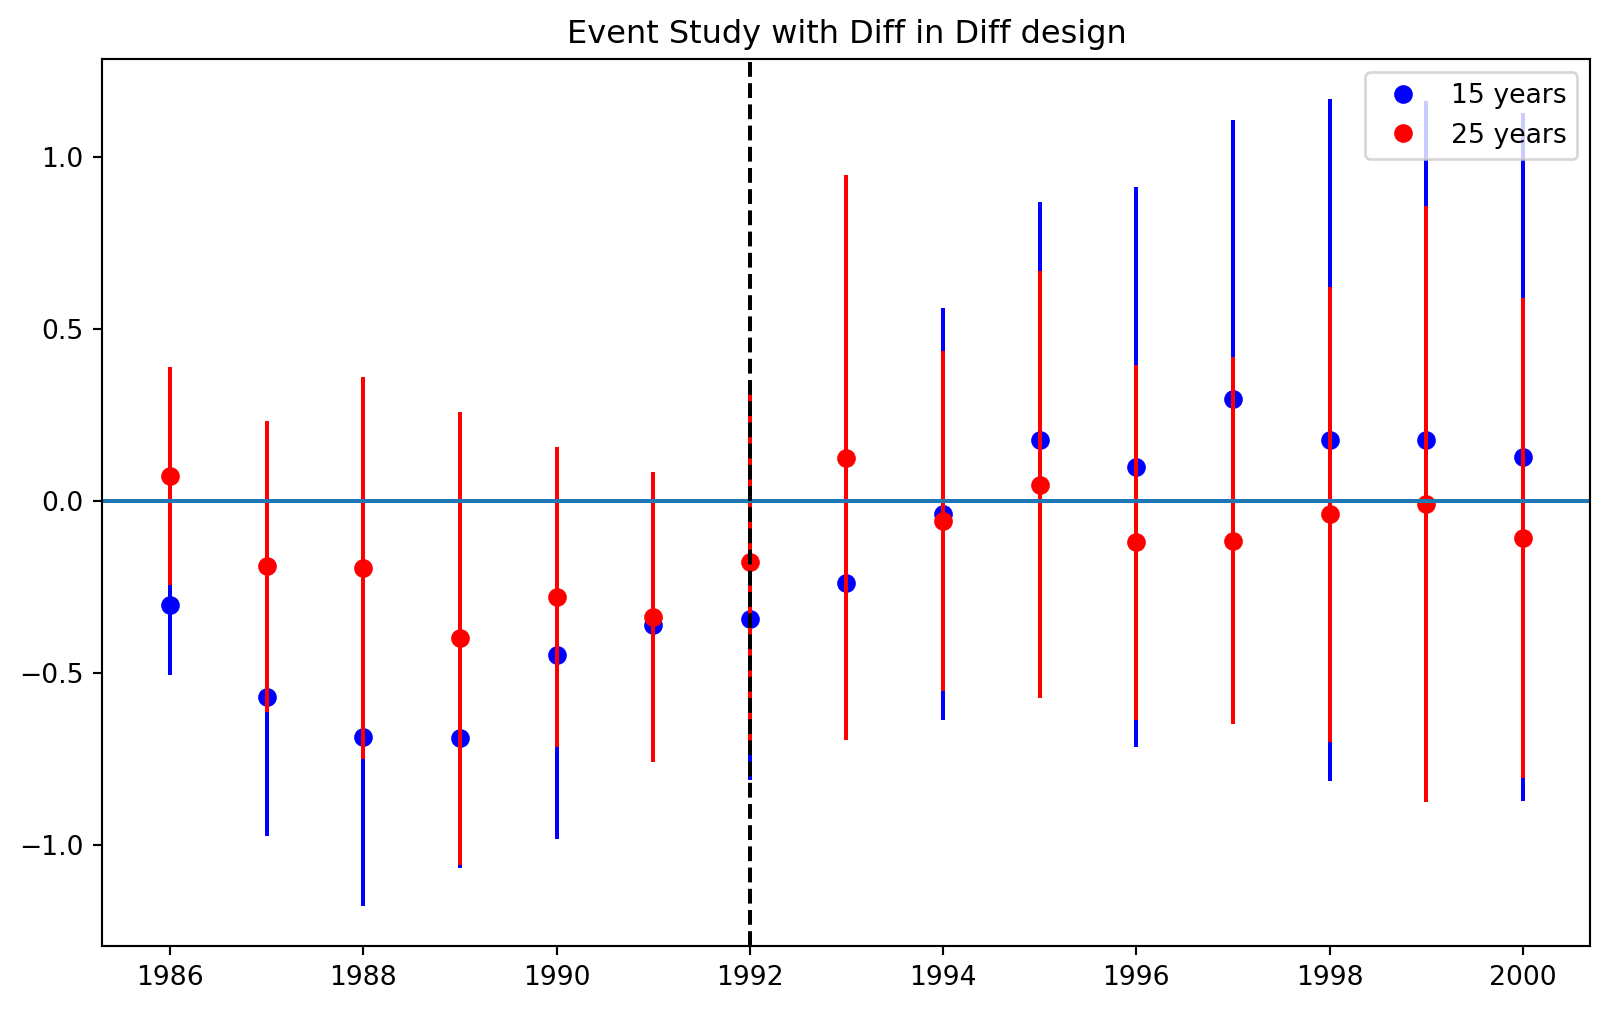

In [16]:
abortion = pd.read_csv('abortion_mixtape.csv')
abortion = abortion[~pd.isnull(abortion.lnr)]

abortion_filt = abortion[(abortion.race == 2) & (abortion.sex == 1) & (abortion.age == 15)]

regdd = (
    smf
    .wls("""lnr ~ C(repeal)*C(year) + C(fip) + acc + ir + pi + alcohol+ crack + poverty+ income+ ur""", 
        data=abortion_filt, weights=abortion_filt.totpop.values)
    .fit(
        cov_type='cluster', 
        cov_kwds={'groups': abortion_filt.fip.values}, 
        method='pinv')
)

abortion_filt = abortion[(abortion.race == 2) & (abortion.sex == 1) & (abortion.age == 25)]

regdd1 = (
    smf
    .wls("""lnr ~ C(repeal)*C(year) + C(fip) + acc + ir + pi + alcohol+ crack + poverty+ income+ ur""", 
        data=abortion_filt, weights=abortion_filt.totpop.values)
    .fit(
        cov_type='cluster', 
        cov_kwds={'groups': abortion_filt.fip.values}, 
        method='pinv')
)

abortion_plot = make_regression_plot(regdd)
abortion_plot1 = make_regression_plot(regdd1)


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(abortion_plot['mean'], 'o', color='blue', label='15 years')[0]
ax.vlines(x=abortion_plot.index, ymin=abortion_plot['lb'], ymax=abortion_plot['ub'], color='blue')
ax.plot(abortion_plot1['mean'], 'o', color='red', label='25 years')[0]
ax.vlines(x=abortion_plot1.index, ymin=abortion_plot1['lb'], ymax=abortion_plot1['ub'], color='red')
ax.axhline(0)
ax.axvline(1992, color='black', linestyle='--')
ax.legend()
ax.set_title("Event Study with Diff in Diff design");

# Conclusion

We have seen here how the difference in differences design for causal inference can lead to compelling analysis of causal claims. We have also seen how we can interrogate the robustness of these claims using a range of model specifications and graphical plots. The literature on the differences in differences is vast and spiralling around complexities of correct estimation under different conditions with time-varying treatment effects. We've only gestured to some of the issues, but I hope you find the experimental design sufficiently interesting to warrant further investigation. 